## Config

In [1]:
import sys
import os
import cv2
import imageio
import random
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm


# !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

sys.path.append("..")
from src.utils import load_config, print_config, set_seed

os.chdir("..")
print(os.getcwd())

/home/ionut/Projects/sdg4ad


In [2]:
cfg = load_config("config/config_synthetic_generation.yaml")
print_config(cfg)
set_seed(cfg["seed"])

Configuration:
seed: 42
file_path: data/Splits/PN/split_1_train.txt
output_path: out/split_1_train_v4
target_size: 720p
sam_checkpoint: weights/sam_vit_b_01ec64.pth
model_type: vit_b
device: cpu
points_per_side: 16
sigma: 5
partition: 50
lower_th_a: 80
upper_th_a: 160
lower_th_b: 80
upper_th_b: 240



## Canny

In [3]:
def get_index_of_edgiest_grape(cfg, imgs):
    """
    Returns the index of the edgiest grape in the list of images.
    
    It uses two Canny edge detectors with different thresholds and returns the index of the image
    with the highest difference in edge count. The edge count is normalized by the image size.

    Args:
        cfg (dict): Configuration dictionary.
        imgs (list): List of images.

    Returns:
        int: Index of the edgiest grape.
    """
    edge_counts = []
    for img in imgs:
        img = cv2.GaussianBlur(img, (cfg["sigma"], cfg["sigma"]), 0)
        num_edges_a = cv2.countNonZero(cv2.Canny(img, cfg["lower_th_a"], cfg["upper_th_a"]))
        num_edges_b = cv2.countNonZero(cv2.Canny(img, cfg["lower_th_b"], cfg["upper_th_b"]))
        non_black_pixels = np.count_nonzero(np.any(img != [0, 0, 0], axis=-1))
        normalized_edge_count = (num_edges_a - num_edges_b) / (non_black_pixels)
        edge_counts.append(normalized_edge_count)
    return np.argmax(edge_counts) 


## SAM

In [4]:
def resize_image(image_path, target_resolution):
    resolutions = {
    "720p": (1280, 720),
    "1080p": (1920, 1080),
    "1440p": (2560, 1440),
    "4k": (3840, 2160)
    }

    target_height, target_width = resolutions[target_resolution]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width = image.shape[:2]

    aspect_ratio = width / height
    target_ratio = target_width / target_height

    if aspect_ratio > target_ratio:
        new_width = target_width
        new_height = int(new_width / aspect_ratio)
    else:
        new_height = target_height
        new_width = int(new_height * aspect_ratio)

    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_CUBIC)

    return resized_image


def get_mask_generator(cfg):
    """
    Returns the SAM mask generator.
    
    Args:
        cfg (dict): The configuration dictionary.
        
    Returns:
        SamAutomaticMaskGenerator: The mask generator.
    """
    sam = sam_model_registry[cfg["model_type"]](checkpoint=cfg["sam_checkpoint"]).to(device=cfg["device"])
    mask_generator = SamAutomaticMaskGenerator(model=sam, points_per_side=cfg["points_per_side"])
    return mask_generator


def filter_masks_by_area(masks, partition):
    # Threhsholds
    grapes_area = np.array([mask['area'] for mask in masks])
    mu = np.mean(grapes_area)
    sigma = np.std(grapes_area)

    k_min=0.1
    k_max=0

    percent_new_masks=0
    while percent_new_masks<=partition and k_max<3:
        new_masks=[]
        k_max+=0.1
        min_mask_region_area = mu - k_min*sigma
        max_mask_region_area = mu + k_max*sigma

        # Filtraggio
        for elem in masks:
            if elem['area'] > min_mask_region_area and elem['area'] < max_mask_region_area:
                new_masks.append(elem)

        len_new_masks = len(new_masks)
        percent_new_masks=(len_new_masks*100)/len(masks)

    return new_masks


def generate_masks(image, mask_generator, partition):
    """
    Generates masks for the input image. The masks are filtered by area.
    
    Args:
        image (np.array): The input image.
        mask_generator (SamAutomaticMaskGenerator): The mask generator.
        partition (float): The partition of the area of the masks to keep.

    Returns:
        list: The generated masks.
    """
    masks = mask_generator.generate(image)
    masks = filter_masks_by_area(masks, partition)
    masks = [mask['segmentation'] for mask in masks]
    return masks

## Utils

In [5]:
def read_file_list(file_path):
  """
  Reads the file list and returns the paths of the good and bad grapes.

  Args:
      file_path (str): The path to the file list.

  Returns:
      list: The paths of the good grapes.
      list: The paths of the bad grapes.
  """
  good_paths = []
  bad_paths = []
  with open(file_path, 'r') as file:
      for line in file:
          path, label = line.strip().split()
          if label == '0':  # Good grape
              good_paths.append(path)
          else:  # Grape with anomaly
              bad_paths.append(path)
  return good_paths, bad_paths


def write_log(index, good_image_path, bad_image_path, log_folder):
    """
    Writes the log of the generated anomaly.

    Args:
        index (int): The index of the anomaly.
        good_image_path (str): The path of the good grape image.
        bad_image_path (str): The path of the bad grape image.
        log_folder (str): The path of the log folder.
    """
    log_folder = os.path.join(log_folder, "logs")
    os.makedirs(log_folder, exist_ok=True)
    with open(os.path.join(log_folder, f"log_anomaly_{index}.txt"), "a") as f:
        f.write(f"Anomaly {index} generated with:\n")
        f.write(f"Good image: {os.path.basename(good_image_path)}\n")
        f.write(f"Bad image: {os.path.basename(bad_image_path)}\n")

## Blending

In [6]:
def PoissonBlending(source, destination, mask_bad, good_mask, cloning_type):
    mask_bad = mask_bad.astype(np.uint8) * 255
    _, _, w_bad, h_bad = cv2.boundingRect(mask_bad)

    good_mask = good_mask.astype(np.uint8) * 255
    x_good, y_good, w_good, h_good = cv2.boundingRect(good_mask)
    center_x = x_good + w_good // 2
    center_y = y_good + h_good // 2

    # Make border around source to make sure that the mask will not be outside the image
    border_x = w_bad // 2 + 1
    border_y = h_bad // 2 + 1
    destination = cv2.copyMakeBorder(destination, border_y, border_y, border_x, border_x, cv2.BORDER_REFLECT)
    p = (center_x + border_x, center_y + border_y)

    blended = cv2.seamlessClone(source, destination, mask_bad, p, cloning_type) # cv::MIXED_CLONE = 2

    # Remove the border
    blended = blended[border_y:-border_y, border_x:-border_x]

    return blended

## Main

In [7]:
def generate_synthetic_image(cfg, img_good, img_bad, mask_generator):
    # Segmentation and extraction of good grape
    good_masks = generate_masks(img_good, mask_generator, cfg["partition"])
    good_idx = random.randint(0, len(good_masks) - 1)   # Choose a random good grape
    good_grapes = [img_good * mask[:,:,None] for mask in good_masks]
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(good_masks[good_idx])
    plt.title("Good mask")
    plt.subplot(1, 2, 2)
    plt.imshow(good_grapes[good_idx])
    plt.title("Good grape")
    plt.show()

    # Segmentation and extraction of bad grape
    bad_masks = generate_masks(img_bad, mask_generator, cfg["partition"])
    bad_grapes = [img_bad * mask[:,:,None] for mask in bad_masks]
    bad_idx = get_index_of_edgiest_grape(cfg, bad_grapes)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(bad_masks[bad_idx].astype(np.uint8))
    plt.title("Bad mask")
    plt.subplot(1, 2, 2)
    plt.imshow(bad_grapes[bad_idx])
    plt.title("Bad grape")
    plt.show()

    blended = PoissonBlending(bad_grapes[bad_idx], img_good, bad_masks[bad_idx], good_masks[good_idx], cv2.NORMAL_CLONE)
    plt.imshow(blended)
    plt.show()
    return blended

Processing images:   0%|          | 0/320 [00:00<?, ?it/s]

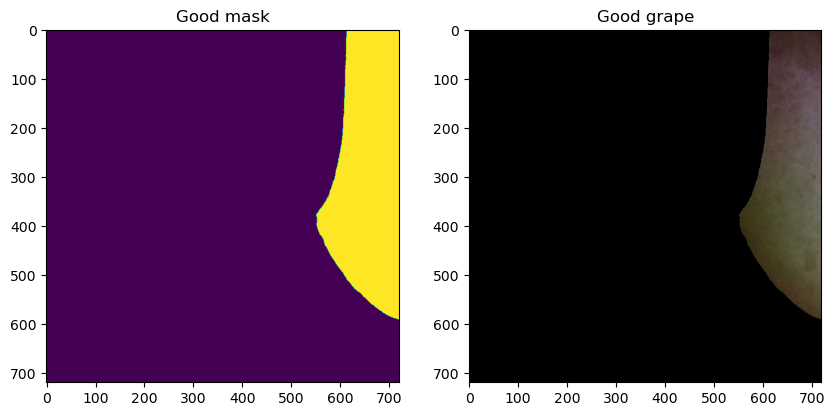

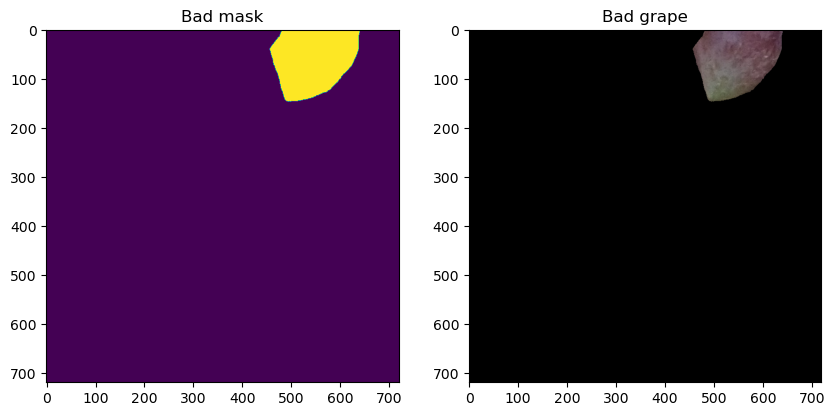

Destination shape:  (720, 720, 3)
Source shape:  (720, 720, 3)
Center 635 296
Border x:  93 Border y:  75
Center with border:  (728, 371)
(720, 720, 3)


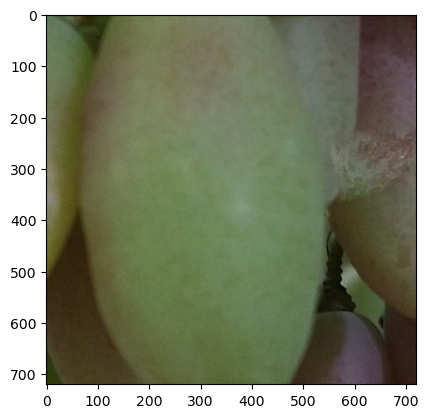

Processing images:   1%|          | 2/320 [00:27<1:12:04, 13.60s/it]

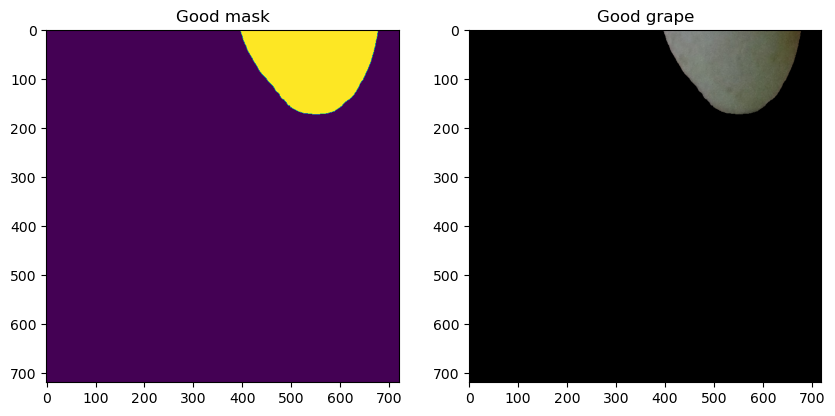

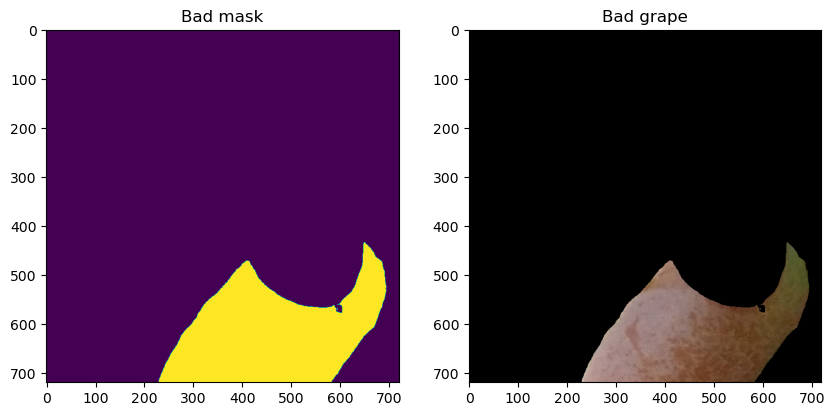

Destination shape:  (720, 720, 3)
Source shape:  (720, 720, 3)
Center 537 87
Border x:  233 Border y:  143
Center with border:  (770, 230)
(720, 720, 3)


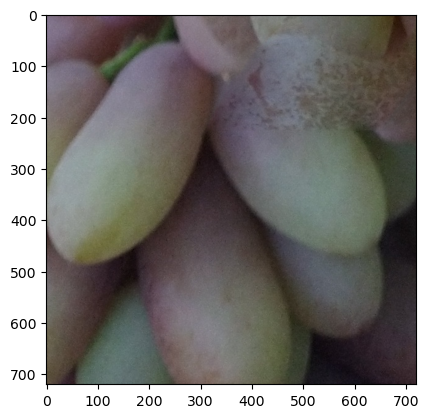

Processing images:   1%|          | 3/320 [00:56<1:45:22, 19.94s/it]

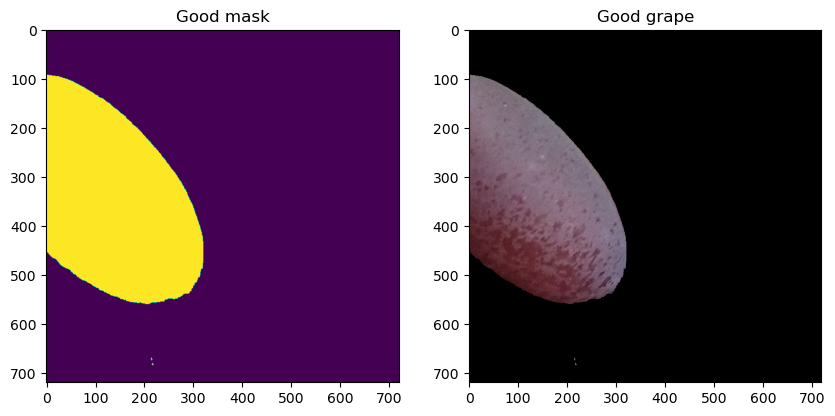

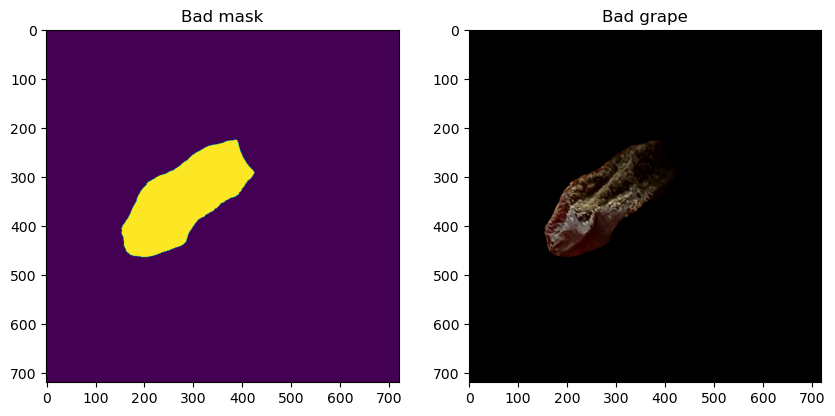

Destination shape:  (720, 720, 3)
Source shape:  (720, 720, 3)
Center 160 389
Border x:  136 Border y:  120
Center with border:  (296, 509)
(720, 720, 3)


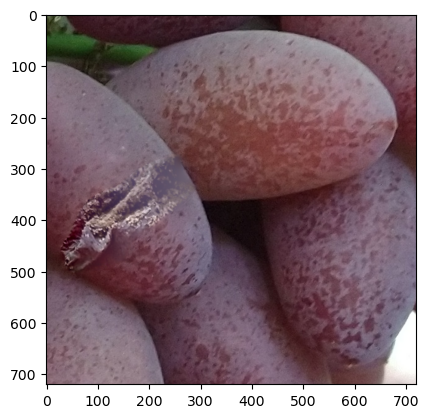

Processing images:   1%|          | 3/320 [01:25<2:30:39, 28.51s/it]


In [8]:
mask_generator = get_mask_generator(cfg)
good_image_paths, bad_image_paths = read_file_list(cfg["file_path"])
log_folder = os.path.join(cfg["output_path"], "logs")
os.makedirs(log_folder, exist_ok=True)

num_good_images = len(good_image_paths)
num_bad_images = len(bad_image_paths)
for index, good_image_path in tqdm(enumerate(good_image_paths), desc="Processing images", total=num_good_images):
    bad_image_path = bad_image_paths[index % num_bad_images]

    img_good = resize_image(good_image_path, cfg["target_size"])
    img_bad = resize_image(bad_image_path, cfg["target_size"])

    new_img = generate_synthetic_image(cfg, img_good, img_bad, mask_generator)
    
    write_log(index, good_image_path, bad_image_path, log_folder)
    imageio.imsave(f"{cfg['output_path']}/anomaly_{index}.jpg", new_img)
    
    if index == 3:  ###
        break  ###